# ALTERNATIVE MODELS

## With ICC-paper feature vector

(You can run only the next two cells and skip to the next step if you already have the model pickled)

Once the loader has loaded the data and applied the transformations, we can load the resulting parquets and prepare for model training. We then split the data into training and test sets and train a model.

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq

phishing = pq.read_table('floor/phishing_2307.parquet')
benign = pq.read_table('floor/benign_2307.parquet')

from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
phishing = drop_nontrain(phishing)
benign = drop_nontrain(benign)

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(phishing.schema)

# concatentate tables
data = pa.concat_tables([phishing, benign])
df = data.to_pandas()

print(f"Total records: {len(df)}")

from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)

used_features = [

    # IP  ===============================
    # Used in the original NOMS paper
    "ip_mean_average_rtt",
    "ip_entropy",
    "ip_count",
    #"ip_v4_count", "ip_v6_count", # Moved RDAP and RENAMED to rdap_ip
    
    # Newly added for ICC
    "ip_v4_ratio",
    "ip_a_aaaa_to_all_ratio",
    "ip_as_address_entropy",
    "ip_asn_entropy",
    "ip_distinct_as_count",
    
    # DNS  ===============================
    # Used in the original NOMS paper
    "dns_A_count",
    "dns_AAAA_count",
    "dns_MX_count",
    "dns_NS_count",
    "dns_SOA_count",
    "dns_TXT_count",
    "dns_CNAME_count",
    "dns_soa_primary_ns_len",
    "dns_soa_primary_ns_level", # renamed
    "dns_soa_primary_ns_digit_count",
    "dns_soa_primary_ns_entropy",
    "dns_soa_email_len",
    "dns_soa_email_level", # renamed
    "dns_soa_email_digit_count",
    "dns_soa_email_entropy",
    # "dns_soa_serial", <-- Doesn't convey any kind of comparative information
    "dns_soa_refresh",
    "dns_soa_retry",
    "dns_soa_expire",
    "dns_mx_avg_len",
    "dns_mx_avg_entropy",
    "dns_domain_name_in_mx",
    "dns_txt_spf_exists",
    "dns_txt_avg_entropy",
    "dns_txt_dkim_exists",
    
    "dns_zone_level",
    "dns_zone_digit_count",
    "dns_zone_len",
    "dns_zone_entropy",
    
    # Newly added for ICC
    "dns_resolved_record_types",
    "dns_has_dnskey",
    "dns_dnssec_score",
    "dns_ttl_avg",
    "dns_ttl_stdev",
    "dns_ttl_low",
    "dns_ttl_mid",
    "dns_ttl_distinct_count",
    "dns_soa_min_ttl", # why is this not in NOMS?!
    "dns_txt_external_verification_score",
    "dns_txt_dmarc_exists",
    
    
    # TLS  ===============================
    # Used in the original NOMS paper
    "tls_broken_chain",
    "tls_expired_chain",
    "tls_total_extension_count",
    "tls_critical_extensions",
    "tls_with_policies_crt_count",
    "tls_percentage_crt_with_policies",
    "tls_x509_anypolicy_crt_count",
    "tls_iso_policy_crt_count",
    "tls_joint_isoitu_policy_crt_count",
    # "tls_iso_policy_oid", <-- Basically a random value, doesn't make much sense when collected like this; policy OIDs need more research
    # "tls_isoitu_policy_oid", <-- same
    #"tls_unknown_policy_crt_count", <-- Abandoned, no useful values
    "tls_root_cert_validity_len",
    "tls_leaf_cert_validity_len",
    "tls_chain_len",
    "tls_root_cert_lifetime",
    "tls_leaf_cert_lifetime",
    "tls_subject_count",
    "tls_unique_SLD_count",
    "tls_server_auth_crt_count",
    "tls_client_auth_crt_count",
    "tls_CA_certs_in_chain_ratio",
    "tls_common_name_count",
    
    # Newly added for ICC
    "tls_has_tls",
    "tls_negotiated_version_id",
    "tls_negotiated_cipher_id",
    
    # LEX ===============================
    # Used in the original NOMS paper
    "lex_name_len",
    #"lex_digit_count", <-- abandoned, almost the same as "lex_sub_digit_ratio"
    "lex_has_digit",
    "lex_phishing_keyword_count",
    #"lex_vowel_count", <-- moved to sub
    #"lex_underscore_hyphen_count", <--- same as nonalnum
    "lex_consecutive_chars",
    "lex_tld_len",
    "lex_sld_len",
    "lex_sub_count",
    "lex_stld_unique_char_count",
    "lex_begins_with_digit",
    "lex_www_flag",
    "lex_sub_max_consonant_len",
    "lex_sub_norm_entropy",
    "lex_sub_digit_count",
    "lex_sub_digit_ratio",
    "lex_sub_consonant_ratio",
    "lex_sub_non_alphanum_ratio",
    "lex_sub_hex_ratio",
    "lex_sld_norm_entropy", # <-- newly added feature on 24-09-29
    
    # Newly added for ICC
    "lex_bigram_matches",
    "lex_trigram_matches",
    "lex_sub_vowel_count",
    "lex_sub_vowel_ratio",
    "lex_sub_consonant_count",
    "lex_sub_non_alphanum_count",
    "lex_sub_hex_count",
    "lex_avg_part_len",
    "lex_stdev_part_lens",
    "lex_longest_part_len",
    "lex_shortest_sub_len",
    
    # RDAP ===============================
    # Used in the original NOMS paper
    "rdap_registration_period",
    "rdap_domain_age",
    "rdap_time_from_last_change",
    "rdap_domain_active_time",
    "rdap_has_dnssec",
    
    "rdap_ip_v4_count", "rdap_ip_v6_count", # <-- used for NOMS, but now prefixed with rdap_
    
    # Newly added for ICC
    "rdap_registrar_name_len",
    "rdap_registrar_name_entropy",
    "rdap_registrar_name_hash",
    "rdap_registrant_name_len",
    "rdap_registrant_name_entropy",
    "rdap_admin_name_len",
    "rdap_admin_name_entropy",
    "rdap_admin_email_len",
    "rdap_admin_email_entropy",
    
    "rdap_ip_shortest_v4_prefix_len",
    "rdap_ip_longest_v4_prefix_len",
    "rdap_ip_shortest_v6_prefix_len",
    "rdap_ip_longest_v6_prefix_len",
    
    "rdap_ip_avg_admin_name_len",
    "rdap_ip_avg_admin_name_entropy",
    "rdap_ip_avg_admin_email_len",
    "rdap_ip_avg_admin_email_entropy",
    
    # GEO ===============================
    # Used in the original NOMS paper
    "geo_countries_count",
    "geo_continent_hash",
    "geo_countries_hash",
    
    # Newly added for ICC
    "geo_lat_stdev", # <- Puvodne to pridal Adam, ale pak jsme dali pryc, ze to budem resit jinak.
    "geo_lon_stdev"  #    Ale muze byt helpful pro identifikaci, jestli lokality jsou blizko sebe.
]


print("Number of used features: " + str(len(used_features)))

# NUMBER OF AVAILABLE AND UNUSED FEATURES
missing_columns = set(df.columns) - set(used_features) - set(["label"])
print("No. of available unused features: " + str(len(missing_columns)))

df = df[["label", *used_features]]


Total records: 469565
Number of used features: 128
No. of available unused features: 0


## Shortening feature names (for paper purposes)

In [2]:
shortening = {
    "lex_stld_unique_char_count": "lex_stld_uniq_char_cnt",
    "lex_sub_max_consonant_len": "lex_max_conson_len",
    "lex_sub_non_alphanum_count": "lex_sub_nonalnum_count",
    "lex_sub_non_alphanum_ratio": "lex_sub_nonalnum_ratio",
    
    "dns_resolved_record_types": "dns_resolved_rec_types",
    "dns_domain_name_in_mx": "dns_dn_in_mx",
    "dns_txt_external_verification_score": "dns_txt_ext_verif_score",
    "dns_zone_digit_count": "dns_zone_digits",
    "dns_soa_primary_ns_digit_count": "dns_soa_prim_ns_digits",
    "dns_soa_primary_ns_len" : "dns_soa_pri_ns_len",
    "dns_soa_primary_ns_level": "dns_soa_pri_ns_level",
    "dns_soa_primary_ns_entropy": "dns_soa_pri_ns_entropy",
    "dns_soa_email_digit_count": "dns_soa_email_digits",
    
    "tls_percentage_crt_with_policies": "tls_percentage_with_policies",
    "tls_x509_anypolicy_crt_count": "tls_x509_anypol_crt_count",
    "tls_iso_policy_crt_count": "tls_iso_pol_crt_count",
    "tls_joint_isoitu_policy_crt_count": "tls_isoitu_pol_crt_count",
    
    "rdap_ip_avg_admin_name_entropy": "rdap_ip_avg_admin_name_ent",
    "rdap_ip_avg_admin_email_entropy": "rdap_ip_avg_admin_email_ent"
}

df.rename(columns=shortening, inplace=True)

df

,label,ip_mean_average_rtt,ip_entropy,ip_count,ip_v4_ratio,ip_a_aaaa_to_all_ratio,ip_as_address_entropy,ip_asn_entropy,ip_distinct_as_count,dns_A_count,...,rdap_ip_longest_v6_prefix_len,rdap_ip_avg_admin_name_len,rdap_ip_avg_admin_name_ent,rdap_ip_avg_admin_email_len,rdap_ip_avg_admin_email_ent,geo_countries_count,geo_continent_hash,geo_countries_hash,geo_lat_stdev,geo_lon_stdev
0,misp_2307:phishing,93.0610,1.0,2,1.0,1.0,1.0,-0.0,1.0,2,...,0.0,13.0,0.249146,23.0,0.149881,1,2,1800,0.00000,0.0000
1,misp_2307:phishing,0.0000,-0.0,1,1.0,1.0,-0.0,-0.0,1.0,1,...,0.0,0.0,0.000000,0.0,0.000000,1,3,184,0.00000,0.0000
2,misp_2307:phishing,-1.0000,-0.0,0,0.0,0.0,NaN,NaN,NaN,0,...,0.0,0.0,0.000000,0.0,0.000000,0,0,0,0.00000,0.0000
3,misp_2307:phishing,3.4960,-0.0,1,0.0,0.0,-0.0,-0.0,1.0,0,...,0.0,19.0,0.182703,23.0,0.154588,1,1,600,0.00000,0.0000
4,misp_2307:phishing,0.0000,-0.0,1,1.0,1.0,-0.0,-0.0,1.0,1,...,0.0,0.0,0.000000,0.0,0.000000,1,0,144,0.00000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469560,benign_2307:unknown,165.7385,-0.0,2,1.0,1.0,-0.0,-0.0,1.0,2,...,0.0,10.0,0.332193,26.0,0.143050,1,2,1800,0.00000,0.0000
469561,benign_2307:unknown,3.8575,-0.0,2,0.5,1.0,-0.0,1.0,2.0,1,...,28.0,10.0,0.292193,23.0,0.157442,1,2,1800,0.00000,0.0000
469562,benign_2307:unknown,0.0000,1.0,2,1.0,1.0,1.0,-0.0,1.0,2,...,0.0,13.0,0.249146,23.0,0.149881,1,10,172,0.00000,0.0000
469563,benign_2307:unknown,20.5390,-0.0,2,0.5,1.0,-0.0,-0.0,1.0,1,...,64.0,0.0,0.000000,0.0,0.000000,1,6,130,1.19615,2.3587


# NaNs will be replaced by -1
## Some classifiers cannot handle NaN values
Replacing by -1 gave better results (for xgboost) than 0

In [3]:
# Handle NaNs
df.fillna(-1, inplace=True)

# Train-Test split

In [4]:
from config import Config
from sklearn.model_selection import train_test_split

class_map = {"benign_2307:unknown": 0, "misp_2307:phishing": 1}

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

X_train, X_test, y_train, y_test = train_test_split(
  features,
  labels,
  test_size=0.3,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# Random Forest

Accuracy: 0.98
Precision: 0.98
Recall: 0.71
F1 Score: 0.82


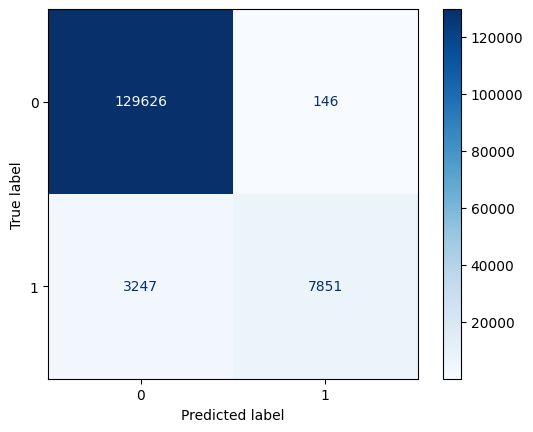

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, det_curve
from matplotlib import pyplot as plt

# Random Forest parameters
params = {
    "n_estimators": 270,
    "max_depth": 9,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "random_state": 7,
}

model = RandomForestClassifier(**params)

# set to True to cross validate
do_cross_val = False
if do_cross_val:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# at last, train the model
_ = model.fit(X_train, y_train)

# If you want to evaluate the model on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision: {precision_score(y_test, y_pred):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
plt.show()  # Show the plot

# Decision tree

Accuracy: 0.97
Precision: 0.94
Recall: 0.71
F1 Score: 0.81


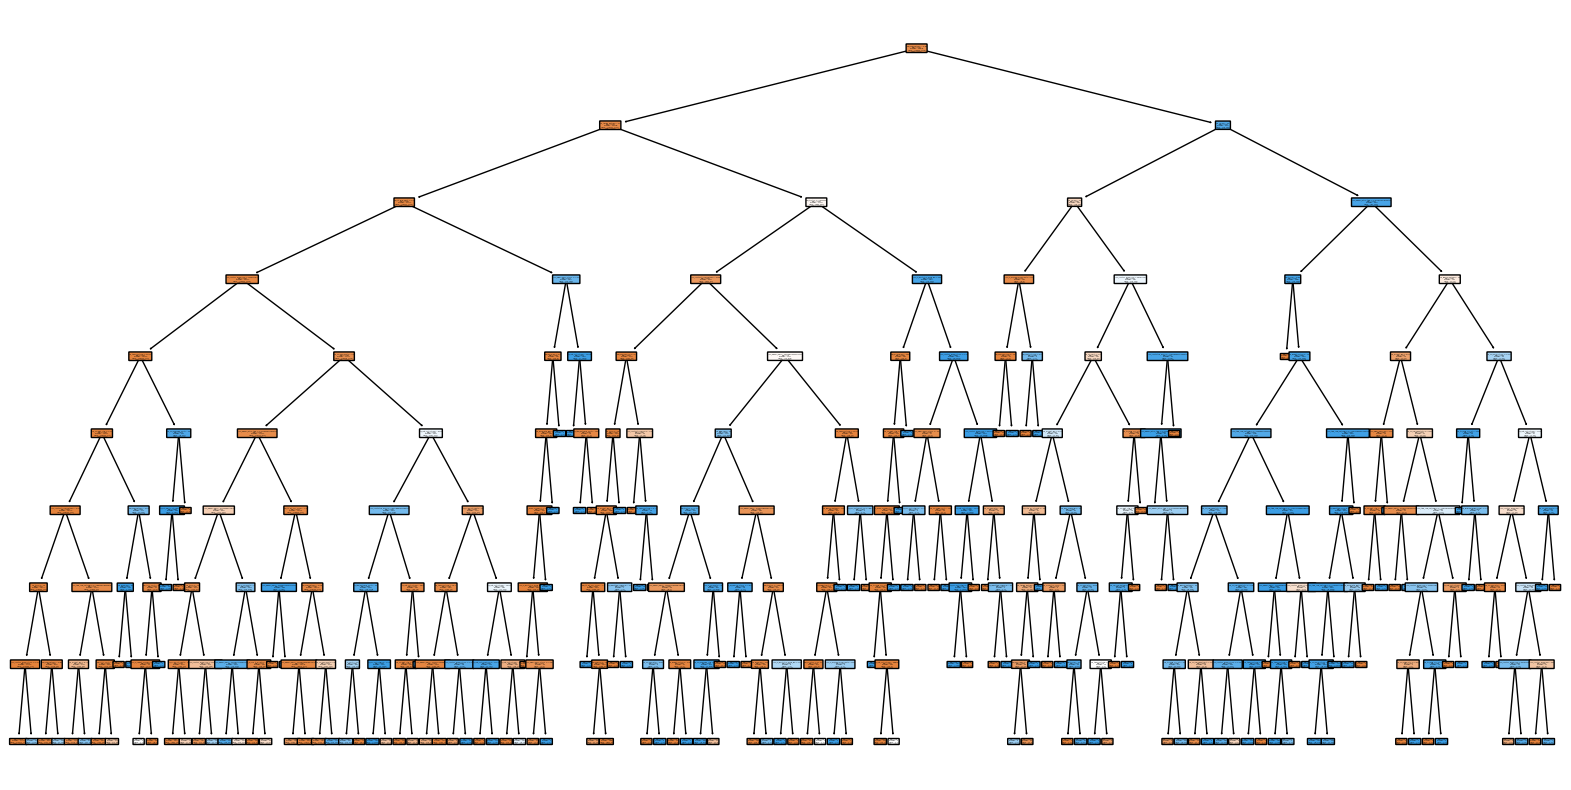

<Figure size 640x480 with 0 Axes>

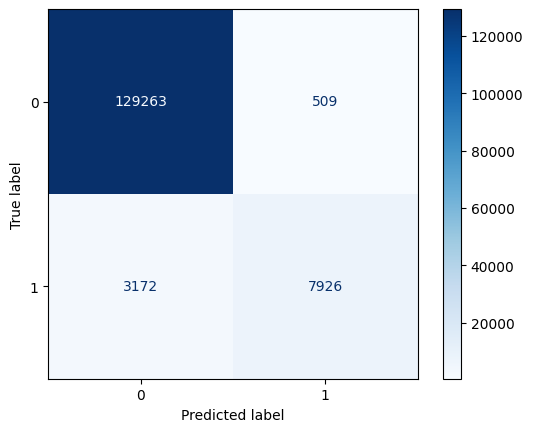

In [14]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree parameters
params = {
    "max_depth": 9,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "random_state": 7,
}

model = DecisionTreeClassifier(**params)

# set to True to cross validate
do_cross_val = False
if do_cross_val:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# at last, train the model
_ = model.fit(X_train, y_train)

# If you want to evaluate the model on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision: {precision_score(y_test, y_pred):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')


from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# To visualize the trained Decision Tree
#plt.figure(figsize=(20, 10))  # Set the figure size, you may need to adjust this to fit the tree
plt.figure(figsize=(20, 10))  # Set the figure size, you may need to adjust this to fit the tree
plot_tree(model, filled=True, feature_names=X_train.columns, class_names=['benign', 'phishing'], rounded=True)
plt.show()

plt.savefig('decision_tree.pdf', format='pdf', bbox_inches='tight')  # Save the plot to a PDF file

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
plt.show()  # Show the plot

# ADABoost

Accuracy: 0.99
Precision: 0.96
Recall: 0.87
F1 Score: 0.91


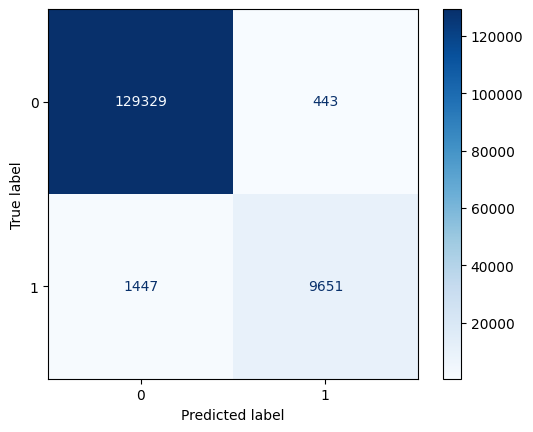

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# AdaBoost parameters
params = {
    "n_estimators": 450,  # Number of weak learners to train iteratively
    "random_state": 7,  # It will control the randomness of the algorithm
}

model = AdaBoostClassifier(**params)

# set to True to cross validate
do_cross_val = False
if do_cross_val:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# at last, train the model
_ = model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision: {precision_score(y_test, y_pred, zero_division=1):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
plt.show()  # Show the plot


In [16]:
# Hyperparameter tuning
run_grid_search = False  # <--------------- TADY JE POTREBA TO ZAPNOUT (pokud chces tunit)
if run_grid_search:
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import AdaBoostClassifier  # Updated import
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold
    import matplotlib.pyplot as plt
    from numpy import array
    from numpy.ma import masked_array

    class_map = {"benign_2307:unknown": 0, "misp_2307:phishing": 1}
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1).copy()
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    params = {
        'random_state': 7,
    }

    clf = AdaBoostClassifier(**params)  # Updated classifier instantiation

    # this is your grid of parameters to search through, every combination will be tried
    grid = {
        "n_estimators": [150, 200, 250, 300, 350, 400, 450],
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=grid,
        #n_jobs=-1,
        cv=cv,
        scoring='neg_log_loss',  # 'f1',
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    clf = grid_search.best_estimator_

    scores = pd.DataFrame(grid_search.cv_results_)
    col_names = ['mean_train_score', 'mean_test_score']

    scores = pd.DataFrame(grid_search.cv_results_)

    col_names = ['mean_train_score', 'mean_test_score']
    means_df = scores[col_names]
    ax = means_df.plot(kind='line', grid=True)

    plt.rcParams["figure.figsize"] = [12, 12]
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams["figure.dpi"] = 300

    max_ids = means_df.idxmax(axis=0)

    for i in range(len(max_ids)):
        for col_name in col_names:
            value = means_df[col_name][max_ids[i]]
            id = max_ids[i]

            color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'

            ax.scatter([id], [value],
                      marker='o',
                      color=color,
                      label='point',)

            ax.annotate(str(round(value, 3)) + "_ID=" + str(id),
                        (id, value),
                        xytext=(id + 3, value))

    print(scores)


# LightGBM

[LightGBM] [Info] Number of positive: 25895, number of negative: 302800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12450
[LightGBM] [Info] Number of data points in the train set: 328695, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.078781 -> initscore=-2.459023
[LightGBM] [Info] Start training from score -2.459023
Accuracy: 1.00
Precision: 0.99
Recall: 0.97
F1 Score: 0.98
              precision    recall  f1-score   support

           0     0.9973    0.9988    0.9980    129772
           1     0.9858    0.9679    0.9768     11098

    accuracy                         0.9964    140870
   macro avg     0.9915    0.9834    0.9874    140870
weighted avg     0.9964    0.9964    0.9964    140870



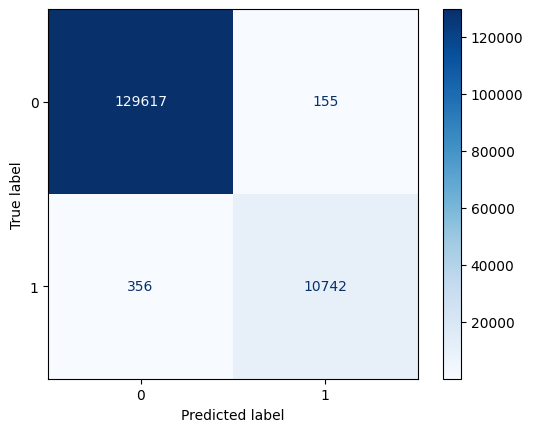

In [17]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# LightGBM parameters
params = {
    'objective': 'binary',  # binary classification
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'n_estimators': 700,  # Number of boosted trees to fit, equivalent to number of boosting iterations
    'num_leaves': 38,
    'random_state': 7,
}

model = lgb.LGBMClassifier(**params)

# set to True to cross validate
do_cross_val = False
if do_cross_val:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# at last, train the model
_ = model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision: {precision_score(y_test, y_pred, zero_division=1):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, det_curve
print(classification_report(y_test, y_pred, digits=4))

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
plt.show()  # Show the plot


In [19]:
# Hyperparameter tuning
run_grid_search = False  # <--------------- TADY JE POTREBA TO ZAPNOUT (pokud chces tunit)
if run_grid_search:
    import pandas as pd
    from sklearn.model_selection import train_test_split
    class_map = {"benign_2307:unknown": 0, "misp_2307:phishing": 1}
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1).copy()
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold
    from lightgbm import LGBMClassifier  # Updated import

    params = {
        'objective': 'binary',  # binary classification
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        #'n_estimators': 50,  # Number of boosted trees to fit, equivalent to number of boosting iterations
        'random_state': 7,
    }

    clf = LGBMClassifier(**params)  # Updated classifier instantiation

    # this is your grid of parameters to search through, every combination will be tried
    grid = {
        "n_estimators": [700],
        "num_leaves": [38],
        #"max_depth": [19,20,21]
        #"learning_rate": [0.05, 0.1, 0.15]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=grid,
        #n_jobs=-1,
        cv=cv,
        #scoring='neg_log_loss',#'f1',
        scoring='f1',#'f1',
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    clf = grid_search.best_estimator_

    scores = pd.DataFrame(grid_search.cv_results_)
    col_names = ['mean_train_score', 'mean_test_score']

    scores = pd.DataFrame(grid_search.cv_results_)

    from numpy import array
    from numpy.ma import masked_array

    col_names = ['mean_train_score', 'mean_test_score']
    means_df = scores[col_names]
    ax = means_df.plot(kind='line', grid=True)

    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [12, 12]
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams["figure.dpi"] = 300

    max_ids = means_df.idxmax(axis=0)

    for i in range(len(max_ids)):
        for col_name in col_names:
            value = means_df[col_name][max_ids[i]]
            id = max_ids[i]

            color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'

            ax.scatter([id], [value],
                      marker='o',
                      color=color,
                      label='point',)

            ax.annotate(str(round(value, 3))+"_ID="+str(id),
                        (id, value),
                        xytext=(id+3, value))

    print(scores)
